In [1]:
import jax.random as jrandom
import numpy as np
import os

from tqdm.notebook import tqdm

from jaxl.constants import *
from jaxl.models.utils import get_model, load_config, load_params, get_wsrl_model, iterate_params, get_policy, policy_output_dim
from jaxl.models.policies import Policy
from jaxl.envs import get_environment
from jaxl.envs.rollouts import EvaluationRollout
from jaxl.utils import get_device, parse_dict

get_device("gpu:0")

In [2]:
env_config = {
    "env_type": "manipulator_learning",
    "env_name": "PandaPlayInsertTrayXYZState",
    "env_kwargs": {
        "main_task": "stack",
        "dense_reward": False
    }
}
env = get_environment(parse_dict(env_config))

pybullet build time: Nov 28 2023 23:45:17
EGL device choice: -1 of 4.


Loaded EGL 1.5 after reload.
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=Quadro RTX 5000 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 535.171.04
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
Version = 3.3.0 NVIDIA 535.171.04
Vendor = NVIDIA Corporation
Renderer = Quadro RTX 5000 with Max-Q Design/PCIe/SSE2


In [3]:
def load_pretrained(learner_path: str, env):
    _, config = load_config(learner_path)
    model_out_dim = policy_output_dim(env.act_dim, config.learner_config)

    if config.learner_config.learner == CONST_BC:
        model = get_model(
            int(np.prod(env.observation_space.shape)) + 1,
            env.act_dim,
            config.model_config
        )
        include_absorbing_state = True
    elif config.learner_config.task == CONST_WSRL:
        model = get_wsrl_model(
            env.observation_space.shape,
            model_out_dim,
            config.model_config.policy
        )
        include_absorbing_state = True
    else:
        model = get_model(
            env.observation_space.shape,
            model_out_dim,
            config.model_config.policy
        )
        include_absorbing_state = False
    params = load_params(f"{learner_path}:latest")

    policy = get_policy(model, config.learner_config)

    return {
        CONST_POLICY: policy,
        CONST_PARAMS: params[CONST_MODEL_DICT][CONST_MODEL][CONST_POLICY],
        "include_absorbing_state": include_absorbing_state
    }


In [4]:
result_dir = "/home/bryan/research/jaxl/logs/manipulator_learning"

ablation_name = "stack"
learner_names = [
    "bc-100k_steps-06-04-24_09_57_35-e8bd5a54-9148-41a9-ace8-f33c5cfbab9f",
    "bc-10k_steps-06-04-24_10_06_35-333b32a8-c019-4fed-9b8f-1ce59166bb2b"
]

pretrained_policies = dict()
for learner_name in learner_names:
    learner_path = os.path.join(result_dir, ablation_name, learner_name)
    pretrained_policies[learner_name] = load_pretrained(learner_path, env)

In [5]:
import chex
import jax.numpy as jnp
import optax

from typing import Any, Dict, Callable, Tuple, Union, Sequence

from jaxl.models.common import Model


class PolicySelector(Policy):
    def __init__(self, models: Sequence[Policy], policy_keys: Sequence[str], p_0: float = 0.5):
        self.policy_keys = policy_keys
        assert len(self.policy_keys) == 2
        self.p_policy = jnp.array([p_0, 1 - p_0])

        self.deterministic_action = self.make_deterministic_action(models)
        self.reset = self.make_reset(models)

    def make_deterministic_action(self, models: Sequence[Policy]) -> Callable:
        def deterministic_action(
            params: Union[optax.Params, Dict[str, Any]],
            obs: chex.Array,
            h_state: chex.Array,
            **kwargs,
        ) -> Tuple[chex.Array, chex.Array]:
            obs_with_abs_state = jnp.concatenate((obs, jnp.array([[0]])), axis=-1)

            acts = []
            for policy_key in self.policy_keys:
                curr_obs = obs
                if models[policy_key]["include_absorbing_state"]:
                    curr_obs = obs_with_abs_state

                act, _ = models[policy_key][CONST_POLICY].deterministic_action(
                    params[policy_key],
                    curr_obs,
                    h_state[0][policy_key],
                    **kwargs
                )
                acts.append(act)
            acts = np.array(acts)

            return np.sum(acts * self.p_policy[:, None, None], axis=0), h_state

        return deterministic_action

    def make_reset(self, models: Sequence[Policy]) -> Callable[..., chex.Array]:
        def _reset() -> chex.Array:
            return {learner_name: models[learner_name][CONST_POLICY].reset() for learner_name in self.policy_keys}

        return _reset

In [6]:
total_episodes = 100
eval_seed = 42
render = False
random = False

In [7]:
policy_keys = list(pretrained_policies.keys())
p_0s = np.arange(0.0, 1.05, 0.05)

In [8]:
print(policy_keys)

results = []
for p_0 in p_0s:
    env = get_environment(parse_dict(env_config))
    rollout = EvaluationRollout(env, eval_seed)
    policy = PolicySelector(pretrained_policies, policy_keys, p_0)
    rollout.rollout(
        {learner_name: pretrained_policy[CONST_PARAMS] for learner_name, pretrained_policy in pretrained_policies.items()},
        policy,
        False,
        total_episodes,
        random=random,
        render=render,
        include_absorbing_state=False,
    )
    results.append((p_0, np.mean(rollout.episodic_returns), np.std(rollout.episodic_returns)))


['bc-100k_steps-06-04-24_09_57_35-e8bd5a54-9148-41a9-ace8-f33c5cfbab9f', 'bc-10k_steps-06-04-24_10_06_35-333b32a8-c019-4fed-9b8f-1ce59166bb2b']
Loaded EGL 1.5 after reload.
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=Quadro RTX 5000 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 535.171.04
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
Version = 3.3.0 NVIDIA 535.171.04
Vendor = NVIDIA Corporation
Renderer = Quadro RTX 5000 with Max-Q Design/PCIe/SSE2
Destroy EGL OpenGL window.


EGL device choice: -1 of 4.
2024-06-05 09:03:32.644851: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
100%|██████████| 100/100 [04:48<00:00,  2.89s/it]
EGL device choice: -1 of 4.


Loaded EGL 1.5 after reload.
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=Quadro RTX 5000 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 535.171.04
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
Version = 3.3.0 NVIDIA 535.171.04
Vendor = NVIDIA Corporation
Renderer = Quadro RTX 5000 with Max-Q Design/PCIe/SSE2
Destroy EGL OpenGL window.


100%|██████████| 100/100 [04:39<00:00,  2.80s/it]
EGL device choice: -1 of 4.


Loaded EGL 1.5 after reload.
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=Quadro RTX 5000 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 535.171.04
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
Version = 3.3.0 NVIDIA 535.171.04
Vendor = NVIDIA Corporation
Renderer = Quadro RTX 5000 with Max-Q Design/PCIe/SSE2
Destroy EGL OpenGL window.


100%|██████████| 100/100 [04:38<00:00,  2.79s/it]
EGL device choice: -1 of 4.


Loaded EGL 1.5 after reload.
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=Quadro RTX 5000 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 535.171.04
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
Version = 3.3.0 NVIDIA 535.171.04
Vendor = NVIDIA Corporation
Renderer = Quadro RTX 5000 with Max-Q Design/PCIe/SSE2
Destroy EGL OpenGL window.


100%|██████████| 100/100 [04:15<00:00,  2.56s/it]
EGL device choice: -1 of 4.


Loaded EGL 1.5 after reload.
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=Quadro RTX 5000 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 535.171.04
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
Version = 3.3.0 NVIDIA 535.171.04
Vendor = NVIDIA Corporation
Renderer = Quadro RTX 5000 with Max-Q Design/PCIe/SSE2
Destroy EGL OpenGL window.


100%|██████████| 100/100 [04:11<00:00,  2.52s/it]
EGL device choice: -1 of 4.


Loaded EGL 1.5 after reload.
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=Quadro RTX 5000 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 535.171.04
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
Version = 3.3.0 NVIDIA 535.171.04
Vendor = NVIDIA Corporation
Renderer = Quadro RTX 5000 with Max-Q Design/PCIe/SSE2
Destroy EGL OpenGL window.


100%|██████████| 100/100 [04:15<00:00,  2.55s/it]
EGL device choice: -1 of 4.


Loaded EGL 1.5 after reload.
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=Quadro RTX 5000 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 535.171.04
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
Version = 3.3.0 NVIDIA 535.171.04
Vendor = NVIDIA Corporation
Renderer = Quadro RTX 5000 with Max-Q Design/PCIe/SSE2
Destroy EGL OpenGL window.


100%|██████████| 100/100 [04:22<00:00,  2.63s/it]
EGL device choice: -1 of 4.


Loaded EGL 1.5 after reload.
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=Quadro RTX 5000 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 535.171.04
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
Version = 3.3.0 NVIDIA 535.171.04
Vendor = NVIDIA Corporation
Renderer = Quadro RTX 5000 with Max-Q Design/PCIe/SSE2
Destroy EGL OpenGL window.


100%|██████████| 100/100 [04:19<00:00,  2.60s/it]
EGL device choice: -1 of 4.


Loaded EGL 1.5 after reload.
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=Quadro RTX 5000 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 535.171.04
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
Version = 3.3.0 NVIDIA 535.171.04
Vendor = NVIDIA Corporation
Renderer = Quadro RTX 5000 with Max-Q Design/PCIe/SSE2
Destroy EGL OpenGL window.


100%|██████████| 100/100 [04:01<00:00,  2.41s/it]
EGL device choice: -1 of 4.


Loaded EGL 1.5 after reload.
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=Quadro RTX 5000 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 535.171.04
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
Version = 3.3.0 NVIDIA 535.171.04
Vendor = NVIDIA Corporation
Renderer = Quadro RTX 5000 with Max-Q Design/PCIe/SSE2
Destroy EGL OpenGL window.


100%|██████████| 100/100 [04:00<00:00,  2.40s/it]
EGL device choice: -1 of 4.


Loaded EGL 1.5 after reload.
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=Quadro RTX 5000 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 535.171.04
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
Version = 3.3.0 NVIDIA 535.171.04
Vendor = NVIDIA Corporation
Renderer = Quadro RTX 5000 with Max-Q Design/PCIe/SSE2
Destroy EGL OpenGL window.


100%|██████████| 100/100 [03:51<00:00,  2.32s/it]
EGL device choice: -1 of 4.


Loaded EGL 1.5 after reload.
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=Quadro RTX 5000 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 535.171.04
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
Version = 3.3.0 NVIDIA 535.171.04
Vendor = NVIDIA Corporation
Renderer = Quadro RTX 5000 with Max-Q Design/PCIe/SSE2
Destroy EGL OpenGL window.


100%|██████████| 100/100 [03:53<00:00,  2.33s/it]
EGL device choice: -1 of 4.


Loaded EGL 1.5 after reload.
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=Quadro RTX 5000 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 535.171.04
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
Version = 3.3.0 NVIDIA 535.171.04
Vendor = NVIDIA Corporation
Renderer = Quadro RTX 5000 with Max-Q Design/PCIe/SSE2
Destroy EGL OpenGL window.


100%|██████████| 100/100 [03:51<00:00,  2.31s/it]
EGL device choice: -1 of 4.


Loaded EGL 1.5 after reload.
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=Quadro RTX 5000 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 535.171.04
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
Version = 3.3.0 NVIDIA 535.171.04
Vendor = NVIDIA Corporation
Renderer = Quadro RTX 5000 with Max-Q Design/PCIe/SSE2
Destroy EGL OpenGL window.


100%|██████████| 100/100 [03:51<00:00,  2.32s/it]
EGL device choice: -1 of 4.


Loaded EGL 1.5 after reload.
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=Quadro RTX 5000 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 535.171.04
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
Version = 3.3.0 NVIDIA 535.171.04
Vendor = NVIDIA Corporation
Renderer = Quadro RTX 5000 with Max-Q Design/PCIe/SSE2
Destroy EGL OpenGL window.


100%|██████████| 100/100 [05:02<00:00,  3.02s/it]
EGL device choice: -1 of 4.


Loaded EGL 1.5 after reload.
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=Quadro RTX 5000 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 535.171.04
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
Version = 3.3.0 NVIDIA 535.171.04
Vendor = NVIDIA Corporation
Renderer = Quadro RTX 5000 with Max-Q Design/PCIe/SSE2
Destroy EGL OpenGL window.


100%|██████████| 100/100 [05:12<00:00,  3.13s/it]
EGL device choice: -1 of 4.


Loaded EGL 1.5 after reload.
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=Quadro RTX 5000 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 535.171.04
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
Version = 3.3.0 NVIDIA 535.171.04
Vendor = NVIDIA Corporation
Renderer = Quadro RTX 5000 with Max-Q Design/PCIe/SSE2
Destroy EGL OpenGL window.


100%|██████████| 100/100 [05:08<00:00,  3.09s/it]
EGL device choice: -1 of 4.


Loaded EGL 1.5 after reload.
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=Quadro RTX 5000 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 535.171.04
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
Version = 3.3.0 NVIDIA 535.171.04
Vendor = NVIDIA Corporation
Renderer = Quadro RTX 5000 with Max-Q Design/PCIe/SSE2
Destroy EGL OpenGL window.


100%|██████████| 100/100 [05:09<00:00,  3.09s/it]
EGL device choice: -1 of 4.


Loaded EGL 1.5 after reload.
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=Quadro RTX 5000 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 535.171.04
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
Version = 3.3.0 NVIDIA 535.171.04
Vendor = NVIDIA Corporation
Renderer = Quadro RTX 5000 with Max-Q Design/PCIe/SSE2
Destroy EGL OpenGL window.


100%|██████████| 100/100 [05:15<00:00,  3.15s/it]
EGL device choice: -1 of 4.


Loaded EGL 1.5 after reload.
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=Quadro RTX 5000 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 535.171.04
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
Version = 3.3.0 NVIDIA 535.171.04
Vendor = NVIDIA Corporation
Renderer = Quadro RTX 5000 with Max-Q Design/PCIe/SSE2
Destroy EGL OpenGL window.


100%|██████████| 100/100 [05:09<00:00,  3.10s/it]
EGL device choice: -1 of 4.


Loaded EGL 1.5 after reload.
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=Quadro RTX 5000 with Max-Q Design/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 535.171.04
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
Version = 3.3.0 NVIDIA 535.171.04
Vendor = NVIDIA Corporation
Renderer = Quadro RTX 5000 with Max-Q Design/PCIe/SSE2
Destroy EGL OpenGL window.


100%|██████████| 100/100 [05:01<00:00,  3.01s/it]


In [9]:
for (p_0, mean_ret, std_ret) in results:
    print("p_0: {} - avg return: {} +/- {}".format(
        p_0,
        mean_ret,
        std_ret
    ))

p_0: 0.0 - avg return: 176.0 +/- 149.26144847213564
p_0: 0.05 - avg return: 197.08 +/- 146.65917496017767
p_0: 0.1 - avg return: 209.1 +/- 142.6280827887692
p_0: 0.15000000000000002 - avg return: 219.75 +/- 140.37595057558826
p_0: 0.2 - avg return: 220.34 +/- 142.13178532615427
p_0: 0.25 - avg return: 235.68 +/- 136.31330676056538
p_0: 0.30000000000000004 - avg return: 230.03 +/- 137.89782123006876
p_0: 0.35000000000000003 - avg return: 251.33 +/- 126.60490156388101
p_0: 0.4 - avg return: 243.98 +/- 131.79165223943434
p_0: 0.45 - avg return: 242.44 +/- 131.40527538877578
p_0: 0.5 - avg return: 254.06 +/- 123.59043814146789
p_0: 0.55 - avg return: 268.28 +/- 113.03062239941883
p_0: 0.6000000000000001 - avg return: 271.28 +/- 109.88913322071478
p_0: 0.65 - avg return: 252.94 +/- 125.41051152116395
p_0: 0.7000000000000001 - avg return: 250.46 +/- 125.8141025481643
p_0: 0.75 - avg return: 274.9 +/- 106.59038418168875
p_0: 0.8 - avg return: 249.95 +/- 128.47057055995356
p_0: 0.8500000000000

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_palette("colorblind")

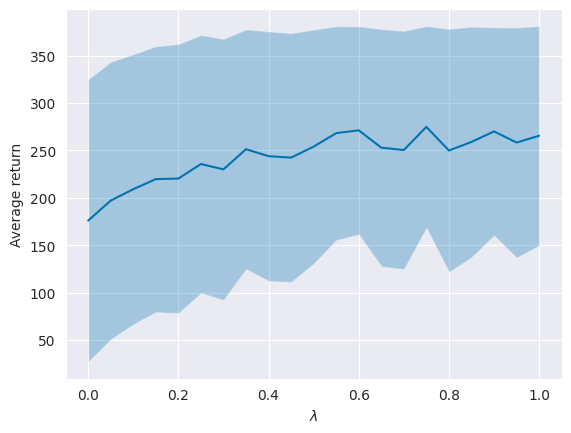

In [11]:
results = np.array(results)

plt.plot(results[:, 0], results[:, 1])
plt.fill_between(results[:, 0], results[:, 1] + results[:, 2], results[:, 1] - results[:, 2], alpha=0.3)
plt.xlabel("$\lambda$")
plt.ylabel("Average return")
plt.savefig("/home/bryan/research/opex_rl/paper/figures/convex_comb_policies.pdf", format="pdf", dpi=400)

10k: (203.98, 147.88853775732588)  
100k: (253.7, 127.34115595517422)  
1M: (215.96, 148.52123888521803)

```
['bc-100k_steps-06-04-24_09_57_35-e8bd5a54-9148-41a9-ace8-f33c5cfbab9f', 'bc-10k_steps-06-04-24_10_06_35-333b32a8-c019-4fed-9b8f-1ce59166bb2b']
2024-06-04 15:40:00.978062: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
  0%|          | 0/50 [00:00<?, ?it/s]
ven = NVIDIA Corporation
ven = NVIDIA Corporation
100%|██████████| 50/50 [08:10<00:00,  9.81s/it]
p_0: 0.0 - avg return: 186.36 +/- 147.89804055497152
100%|██████████| 50/50 [09:46<00:00, 11.72s/it]
p_0: 0.1 - avg return: 228.94 +/- 133.00066315624144
100%|██████████| 50/50 [11:38<00:00, 13.97s/it]
p_0: 0.2 - avg return: 234.7 +/- 134.43812703247542
 76%|███████▌  | 38/50 [09:40<03:37, 18.15s/it]
 ```